Mean reversion strategy: This strategy assumes that the value of a price/return
will return to the average value.
Unlike the mean reversion strategy, pair trading—mean reversion is based on the
correlation between two instruments. If a pair of stocks already has a high
correlation and, at some point, the correlation is diminished, it will come back to
the original level (correlation mean value). If the stock with the lower price
drops, we can long this stock and short the other stock of this pair.

We are going through the process of implementing an example of a pair trading strategy.
The first step is to determine the pairs that have a high correlation. This can be based on the
underlying economic relationship (for example, companies having similar business plans)
or also a financial product created out of some others, such as ETF. Once we figure out
which symbols are correlated, we will create the trading signals based on the value of these
correlations. The correlation value can be the Pearson's coefficient, or a Z-score.

In case of a temporary divergence, the outperforming stock (the stock that moved up)
would have been sold and the underperforming stock (the stock that moved down) would
have been purchased. If the two stocks converge by either the outperforming stock moving
back down or the underperforming stock moving back up, or both, you will make money in
such cases. You won't make money in the event that both stocks move up or down together
with no change in the spread between them. Pairs trading is a market neutral trading
strategy as it allows traders to profit from changing market conditions:

In [5]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.02:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

In [7]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import numpy as np
import statistics as stats
import math as math
import seaborn
from pandas_datareader import data
from statsmodels.tsa.stattools import coint

In [3]:
banks = ['BANKINDIA', 'FEDERALBNK', 'HDFCBANK', 'ICICIBANK', 'SBIN']
bank= pd.DataFrame()

for  t in banks:
    bank[t] =  yf.Ticker(str(t)+'.NS').history(period="10y")['Close']
bank

,BANKINDIA,FEDERALBNK,HDFCBANK,ICICIBANK,SBIN
Date,,,,,
2014-06-02,293.537720,52.904465,375.811249,240.660980,240.465927
2014-06-03,287.963348,52.028713,378.081512,239.699448,240.511368
2014-06-04,292.268768,54.925434,374.572968,245.385696,243.916473
2014-06-05,289.821472,54.813160,372.537811,248.227432,245.303070
2014-06-06,294.761353,56.901485,377.070526,252.154831,249.112778
...,...,...,...,...,...
2024-05-24,129.899994,163.449997,1517.199951,1131.949951,828.599976
2024-05-27,132.449997,163.649994,1527.699951,1129.800049,833.700012
2024-05-28,130.399994,160.000000,1530.500000,1126.949951,831.150024


In [8]:
pvalues, pairs = find_cointegrated_pairs(bank)

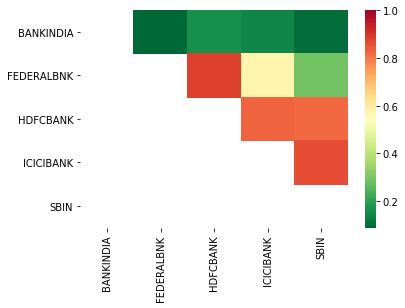

In [13]:
seaborn.heatmap(pvalues, xticklabels=banks,
yticklabels=banks, cmap='RdYlGn_r',
mask = (pvalues >= 0.98))


This code will return the following map as an output. This map shows the pvalues
of the return of the coin:
If a p-value is lower than 0.02, this means the null hypothesis is rejected.
This means that the two series of prices corresponding to two different
symbols can be co-integrated.
This means that the two symbols will keep the same spread on average. On
the heatmap, we observe that the following symbols have p-values lower
than 0.02:

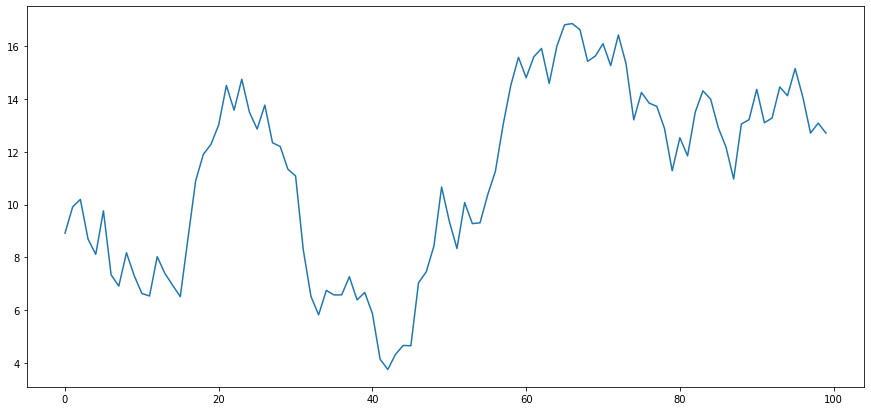

In [15]:
# As shown in the code, let's create a symbol return that we will call Symbol1. The
# value of the Symbol1 price starts from a value of 10 and, every day, it will vary
# based on a random return (following a normal distribution). We will draw the
# price values by using the function plot of the matplotlib.pyplot package:
np.random.seed(123)
# Generate Symbol1 daily returns
Symbol1_returns = np.random.normal(0, 1, 100)
# Create a series for Symbol1 prices
Symbol1_prices = pd.Series(np.cumsum(Symbol1_returns),name='Symbol1') + 10
Symbol1_prices.plot(figsize=(15,7))
plt.show()

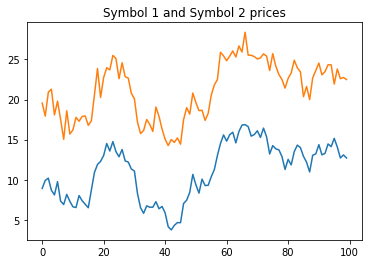

In [16]:
noise = np.random.normal(0, 1, 100)
Symbol2_prices = Symbol1_prices + 10 + noise
Symbol2_prices.name = 'Symbol2'
plt.title("Symbol 1 and Symbol 2 prices")
Symbol1_prices.plot()
Symbol2_prices.plot()
plt.show()

In [17]:
score, pvalue, _ = coint(Symbol1_prices, Symbol2_prices)

In [19]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

# We will define the zscore function. This function returns how far a piece of data
# is from the population mean. This will help us to choose the direction of trading.
# If the return value of this function is positive, this means that the symbol price is
# higher than the average price value. Therefore, its price is expected to go down
# or the paired symbol value will go up. In this case, we will want to short this
# symbol and long the other one. The code implements the zscore function:

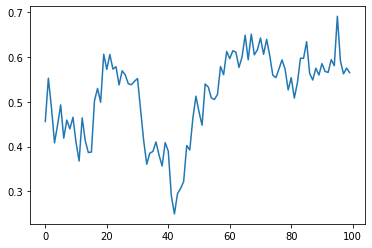

In [20]:
# We will use the ratio between the two symbol prices. We will need to set the
# threshold that defines when a given price is far off the mean price value. For that,
# we will need to use specific values for a given symbol. If we have many symbols
# we want to trade with, this will imply that this analysis be performed for all the
# symbols. Since we want to avoid this tedious work, we are going to normalize
# this study by analyzing the ratio of the two prices instead. As a result, we
# calculate the ratios of the Symbol 1 price against the Symbol 2 price. Let's have a
# look at the code:
    
ratios = Symbol1_prices / Symbol2_prices
ratios.plot()

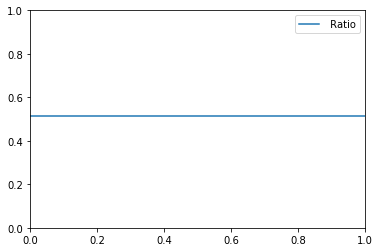

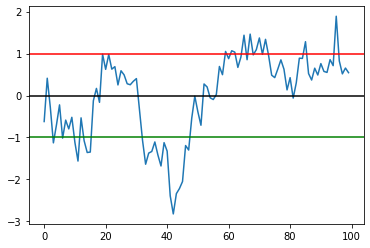

In [22]:
train = ratios[:75]
test = ratios[75:]
plt.axhline(ratios.mean())
plt.legend([' Ratio'])
plt.show()
zscore(ratios).plot()
plt.axhline(zscore(ratios).mean(),color="black")
plt.axhline(1.0, color="red")
plt.axhline(-1.0, color="green")
plt.show()

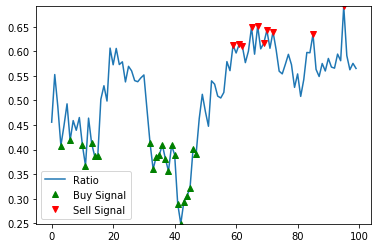

In [23]:
# The Z-score evolution with horizontal lines at -1 (green), +1 (red), and the
# average of Z-score (black).
# The average of Z-score is 0.
# When the Z-score reaches -1 or +1, we will use this event as a trading signal.
# The values +1 and -1 are arbitrary values.
# It should be set depending on the study we will run in order to create this
# trading strategy:
# 12.
ratios.plot()
buy = ratios.copy()
sell = ratios.copy()
buy[zscore(ratios)>-1] = 0
sell[zscore(ratios)<1] = 0
buy.plot(color="g", linestyle="None", marker="^")
sell.plot(color="r", linestyle="None", marker="v")
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(["Ratio", "Buy Signal", "Sell Signal"])
plt.show()

NameError: name 'symbol1_buy' is not defined

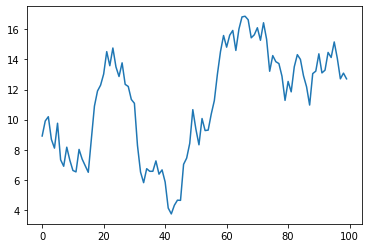

In [24]:
Symbol1_prices.plot()
symbol1_buy[zscore(ratios)>-1] = 0
symbol1_sell[zscore(ratios)<1] = 0
symbol1_buy.plot(color="g", linestyle="None", marker="^")
symbol1_sell.plot(color="r", linestyle="None", marker="v")
Symbol2_prices.plot()
symbol2_buy[zscore(ratios)<1] = 0
symbol2_sell[zscore(ratios)>-1] = 0
symbol2_buy.plot(color="g", linestyle="None", marker="^")
symbol2_sell.plot(color="r", linestyle="None", marker="v")
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,Symbol1_prices.min(),Symbol2_prices.max()))
plt.legend(["Symbol1", "Buy Signal", "Sell Signal","Symbol2"])
plt.show()